# Reliability classifiers 
## Overview 
todo:


## Dimensions for making the problem harder: 
1. Generating from lots of different shape, scale parameters. E.g. wearout_01 has shape=2.0, wearout_02 has shape=4.2, etc. 
2. Varying sample sizes. In particular, smaller sample sizes can be hard to classify
4. Mixtures of distributions. E.g. many IM cases are actually IM+WO
5. Adding noise (e.g. uniform distribution) 

## Next steps 
1. See data gen in 2023-04-17_nn-classifier-for-weibull-shape. Run simple models in that nb and check performance. Use same data gen method from that nb here. 

In [1]:
import sys
print(sys.executable)

/opt/conda/bin/python


In [2]:
import numpy as np
from scipy.stats import weibull_min, uniform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set the random seed
np.random.seed(2023)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problem params 

In [3]:
# Number of samples per class
n_samples_per_class = 10000

# Number of features
n_features = 100

# Scale parameter (constant for both classes)
scale_parameter = 2

# Shape parameters for the two classes
# Values tried: 0.8, 1.0, 
shape_parameter_infant = 0.8
shape_parameter_wearout = 2.0

# Data generation

In [4]:
# Generate samples for class "infant mortality"
infant_mortality_features = weibull_min.rvs(shape_parameter_infant, scale=scale_parameter, size=(n_samples_per_class, n_features))
infant_mortality_labels = np.zeros(n_samples_per_class)


# Generate samples for class "wearout"
## Using Weibull distribution: 
wearout_features = weibull_min.rvs(shape_parameter_wearout, scale=scale_parameter, size=(n_samples_per_class, n_features))
wearout_labels = np.ones(n_samples_per_class)

## Using uniform distribution: 
uniform_features = uniform.rvs(loc=0, scale=scale_parameter*5, size=(n_samples_per_class, n_features))
uniform_labels = np.ones(n_samples_per_class)


# Combine all data
features = np.vstack((infant_mortality_features, wearout_features, uniform_features))
labels = np.concatenate((infant_mortality_labels, wearout_labels, uniform_labels))

In [5]:
# np.random.seed(25)  # todo: delete

# Shuffle the data
shuffle_idx = np.random.permutation(features.shape[0])
features = features[shuffle_idx]
labels = labels[shuffle_idx]

# Convert to a DataFrame for display 
df_data = pd.DataFrame(features)
df_data['class'] = labels
df_data['class_desc'] = df_data['class'].map({0: 'infant mortality', 1: 'wearout'})

In [6]:
df_data.shape

(30000, 102)

In [7]:
# Print the first few rows to check
df_data.head()

# Optionally save to a CSV file
# data.to_csv('weibull_data.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,class,class_desc
0,4.137963,9.042702,2.172171,3.019395,9.889672,9.252647,7.006246,6.397296,0.709416,2.010669,...,1.059144,7.654172,1.688579,3.827446,9.589111,3.202284,1.444636,6.805460,1.0,wearout
1,6.310807,1.084680,0.797153,1.467724,0.386888,6.568531,0.963849,6.889047,4.680548,0.139669,...,10.187727,0.790224,0.512313,1.800655,0.309090,1.993169,2.773991,0.076685,0.0,infant mortality
2,1.394919,1.684457,1.071817,1.381822,1.117905,1.969307,2.585221,2.212096,1.475687,1.451160,...,2.706898,0.925150,1.124490,1.825203,0.633837,2.377684,1.360069,0.848909,1.0,wearout
3,5.020383,4.861626,4.757876,1.643116,9.091743,1.298303,5.651384,8.909929,7.332601,2.971968,...,4.943888,7.015086,1.409226,7.727577,0.756021,4.701781,0.638607,9.958100,1.0,wearout
4,1.160968,1.795109,0.049822,0.804540,1.426331,3.458185,1.973144,1.695443,2.022410,1.381796,...,1.105140,1.814741,1.101556,1.158113,1.169956,1.151355,2.035352,0.665455,1.0,wearout


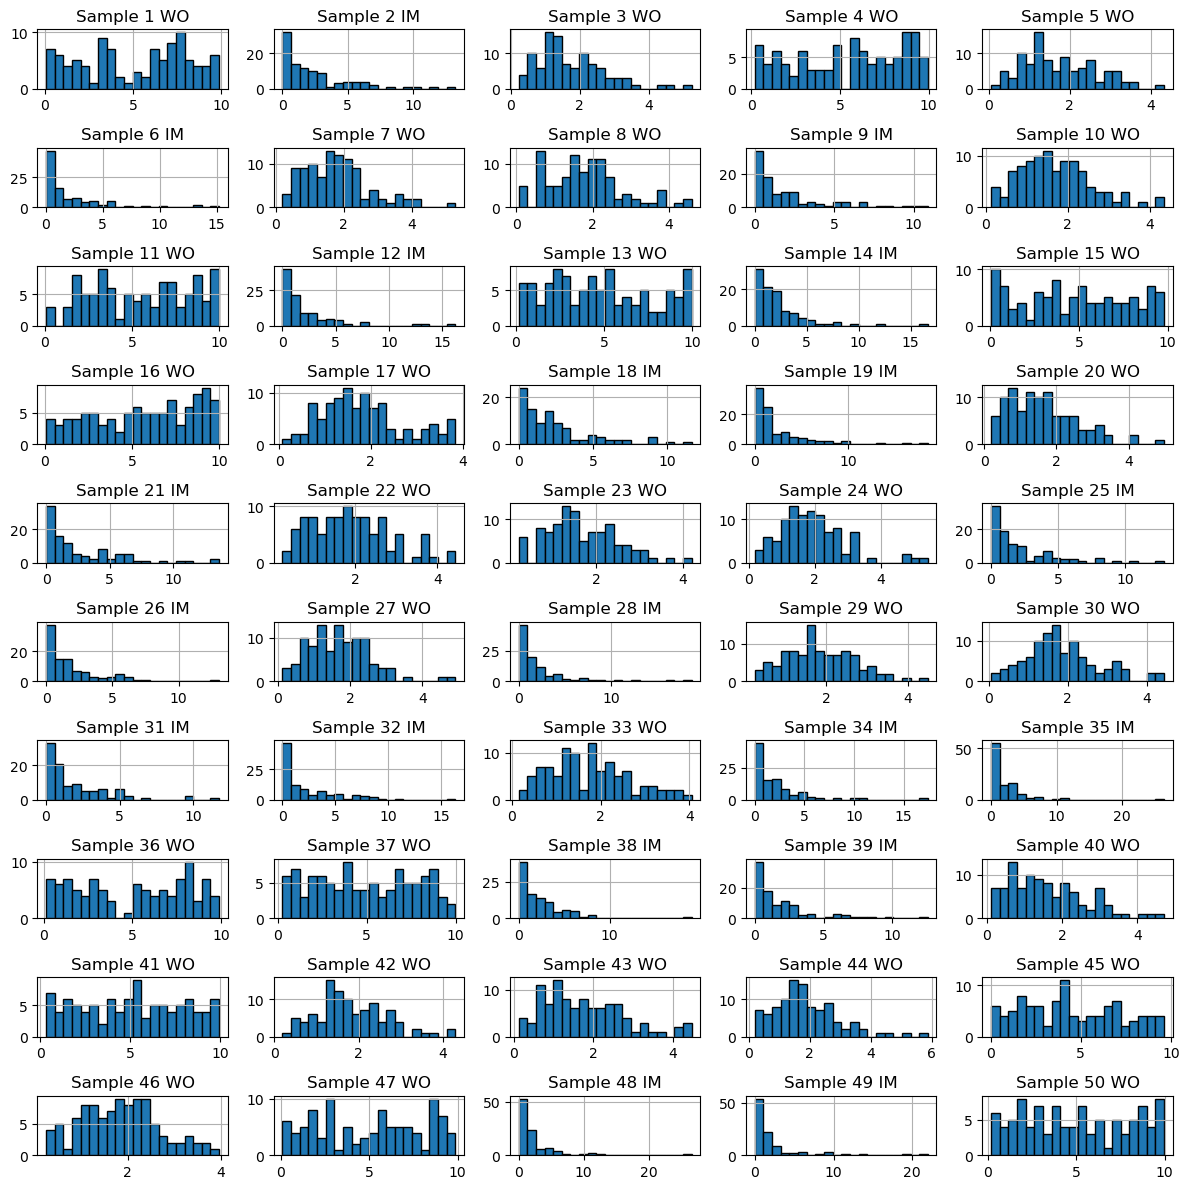

In [8]:
# Select specific rows for visualization (e.g., the 10th sample)
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();


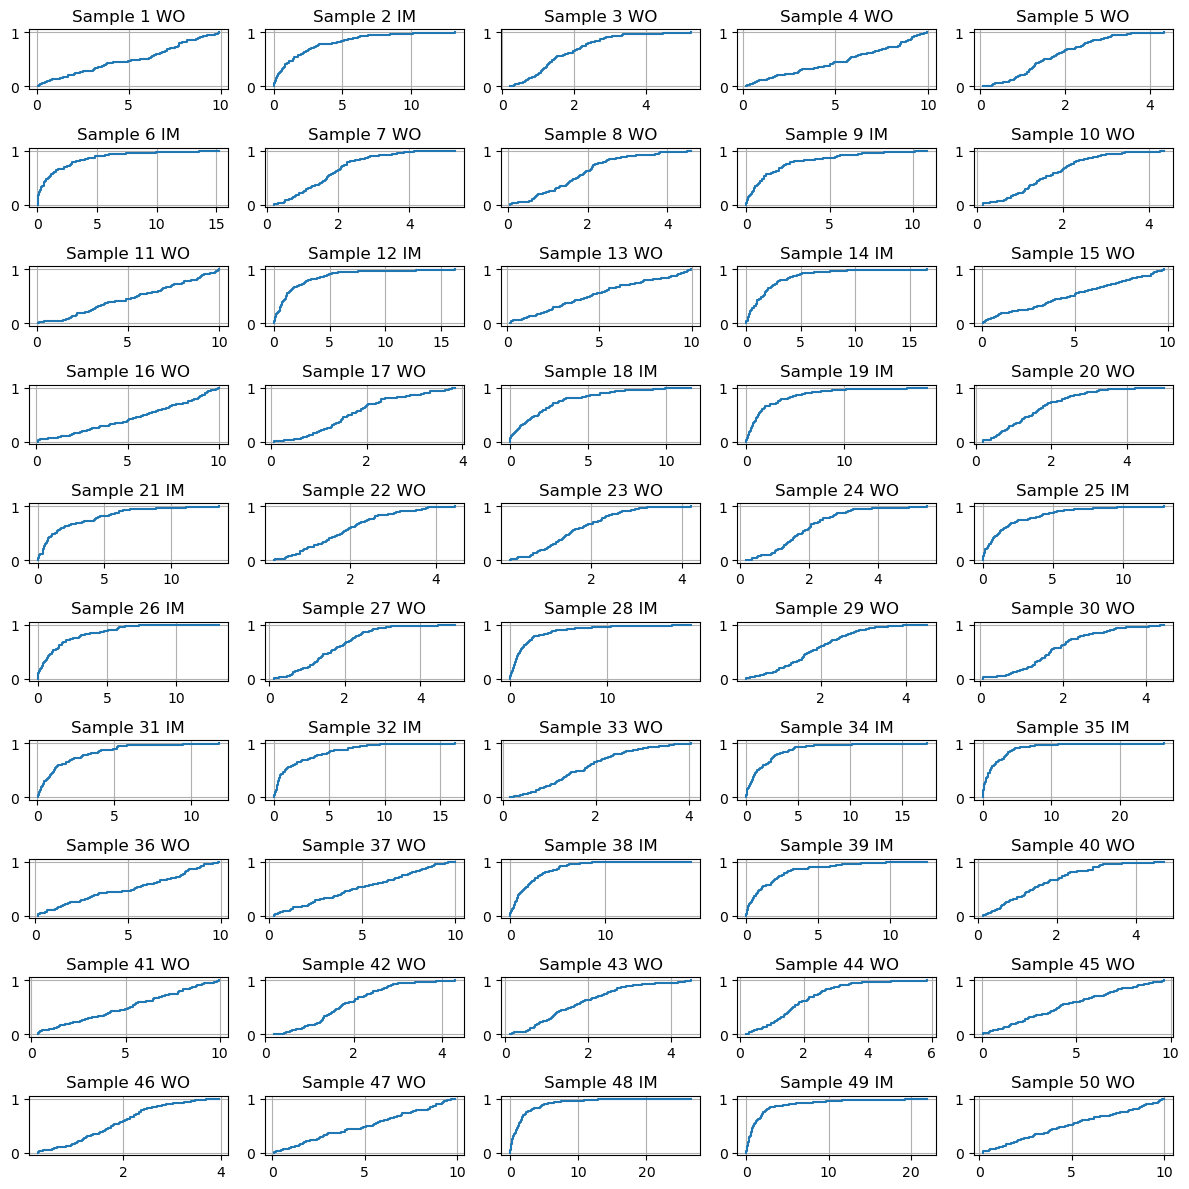

In [9]:
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ecdf = ECDF(selected_sample)

    ax.step(ecdf.x, ecdf.y, where='post')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();

# Train-test split 

In [10]:
X = df_data.iloc[:, :-2].values
X.shape
type(X)

(30000, 100)

numpy.ndarray

In [11]:
y = df_data.iloc[:, -2:-1].values.squeeze()
y.shape 
type(y)

(30000,)

numpy.ndarray

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=2023)

X_train.shape
X_valid.shape 
X_test.shape 

y_train.shape
y_valid.shape
y_test.shape


(19200, 100)

(4800, 100)

(6000, 100)

(19200,)

(4800,)

(6000,)

# Models

In [13]:
model_dict = {
    0: LogisticRegression(random_state=11), 
    1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}

# Training functions and evaluation functions

In [14]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

In [15]:
def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

In [16]:
def train_eval_pipeline(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, X_valid=X_valid)
    evaluate_model(y_valid, preds_valid, model_desc)

# Training and model selection




model: LogisticRegression(random_state=11)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12      1611
         1.0       0.64      0.84      0.73      3189

    accuracy                           0.58      4800
   macro avg       0.43      0.46      0.42      4800
weighted avg       0.50      0.58      0.52      4800



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1611
         1.0       1.00      1.00      1.00      3189

    accuracy                           1.00      4800
   macro avg       1.00      1.00      1.00      4800
weighted avg       1.00      1.00      1.00      4800



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None

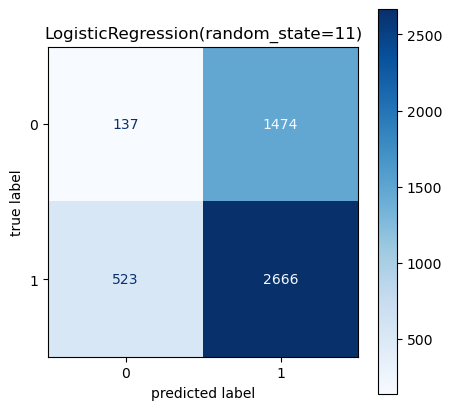

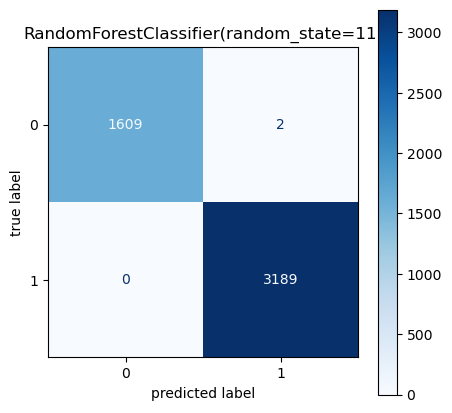

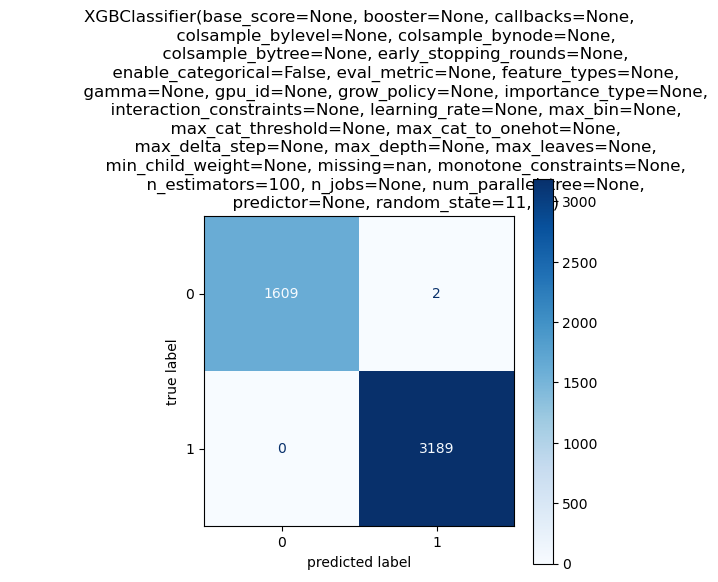

In [17]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)

# Retraining selected model and running inference 

In [18]:
X_train_and_valid = np.concatenate((X_train, X_valid), axis=0)
y_train_and_valid = np.concatenate((y_train, y_valid), axis=0)



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1994
         1.0       1.00      1.00      1.00      4006

    accuracy                           1.00      6000
   macro avg       1.00

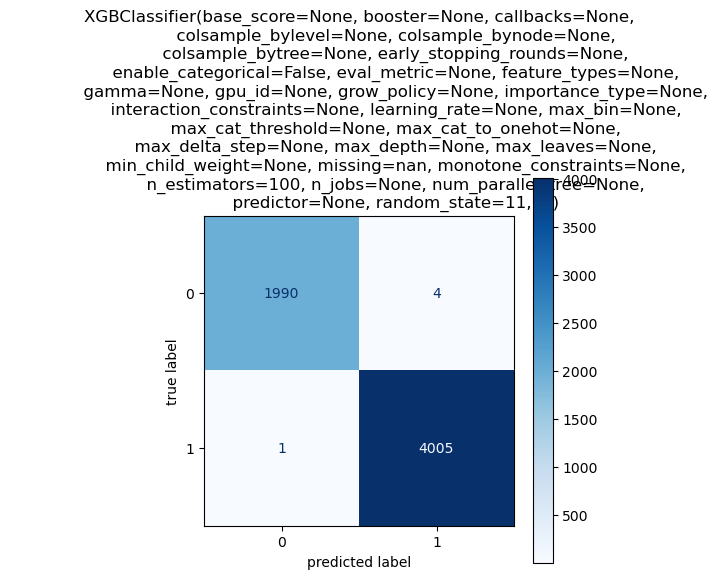

In [19]:
selected_model_num = 2
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)